In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import ipywidgets as widgets
import antropy as ant

In [2]:
FS = 96000
TX_DURATION = 0.1
N = int(TX_DURATION*FS)

In [ ]:
def plot_sequence_of_echoes(repeats, decay_slope, decay_delay, spacing_frac, nfft): 
    spacing = round(spacing_frac, 2)
    sig_time = np.linspace(0, TX_DURATION, N)
    transmit = scipy.signal.chirp(sig_time, 35000, sig_time[-1], 20000)
    window = scipy.signal.windows.hann(N)

    all_sigs_time = np.linspace(0, repeats*TX_DURATION, int(repeats*N))
    sequence_of_echoes = np.zeros(int(repeats*N))
    if spacing!=0:
        for i in np.arange(0, np.floor(spacing*repeats*100)/100, spacing).round(1):
            sequence_of_echoes[int(i*N):int(i*N) + N] += window*transmit
    else:
        for i in range(repeats):
            sequence_of_echoes[:N] += window*transmit

    decay = np.exp(-decay_slope*(all_sigs_time-decay_delay))
    sequence_of_echoes = decay*(sequence_of_echoes)
    hilbert_envelope_of_echoes = np.abs(scipy.signal.hilbert(sequence_of_echoes))

    fig, ax_all = plt.subplots(1, 4, figsize=(16, 4))
    ax = ax_all[0]
    ax.set_title('Temporal sequence of received echoes')
    ax.plot(all_sigs_time, decay, linestyle='dashed', color='k', alpha=0.4, linewidth=2, label='Arbitrary decay function')
    ax.plot(all_sigs_time, -decay, linestyle='dashed', color='k', alpha=0.4, linewidth=2)
    ax.plot(all_sigs_time, sequence_of_echoes, alpha=1, label='Echo sequence')
    ax.set_ylabel('Amplitude')
    ax.set_xlabel('Time (s)')
    ax.legend(loc='lower right')

    ax = ax_all[1]
    ax.set_title('Temporal sequence of received echoes')
    ax.plot(all_sigs_time, decay, linestyle='dashed', color='w', alpha=0.4, linewidth=2)
    ax.plot(all_sigs_time, -decay, linestyle='dashed', color='w', alpha=0.4, linewidth=2)
    ax.plot(all_sigs_time, sequence_of_echoes, alpha=1, color='w')
    ax.plot(all_sigs_time[:N+int((repeats-1)*(N*spacing))], hilbert_envelope_of_echoes[:N+int((repeats-1)*(N*spacing))], label='Hilbert envelope')
    ax.set_ylabel('Amplitude')
    ax.set_xlabel('Time (s)')
    ax.legend(loc='lower right')

    ax = ax_all[2]
    freqs, time, Sxx = scipy.signal.spectrogram(sequence_of_echoes, detrend=False, nfft=nfft, fs=FS)
    Sxx[np.where(Sxx==0)] = 1e-16
    SxxdB = 10 * np.log10(Sxx)
    ax.pcolormesh(time, freqs/1e3, SxxdB, vmin=-60, vmax=-20) # manually plot using plt.pcolormesh
    ax.set_xlim(0, repeats*TX_DURATION)
    ax.set_title('Spectrogram of received echoes')
    ax.set_ylabel('Frequency (kHz)')
    ax.set_xlabel('Time (s)')

    ax = ax_all[3]
    counts, bin_edges = np.histogram(hilbert_envelope_of_echoes[:N+int((repeats-1)*(N*spacing))], bins=50, density=False)
    pmf = counts / counts.sum()
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_widths = np.diff(bin_edges)
    ax.plot(bin_centers, pmf, color='r', linewidth=3, zorder=3)
    ax.bar(bin_centers, pmf, width=bin_widths, align='center', edgecolor='black', alpha=1, zorder=2,
           label=f'Shannon entropy: {-np.sum(pmf[pmf!=0] * np.log2(pmf[pmf!=0])):.2f}\nAntropy spectral entropy: {ant.spectral_entropy(sequence_of_echoes, sf=FS):.2f}')
    ax.set_title('Probability Density Function')
    ax.set_xlabel('Amplitude')
    ax.set_ylabel('Density')
    ax.grid(which='both', zorder=1)
    ax.set_xlim(0, np.ceil(hilbert_envelope_of_echoes.max()-0.01))
    ax.legend()
    
    fig.tight_layout()
    plt.show()

In [69]:
echoes_slider = widgets.IntSlider(
    value=10, min=1, max=10, step=1, description="Num. of echoes", continuous_update=True, style={'description_width': 'initial'}, layout=widgets.Layout(width="300px")
)
decay_slider = widgets.FloatSlider(
    value=0.5, min=-0.5, max=0.5, step=0.01, description="Decay delay (s)", continuous_update=True, style={'description_width': 'initial'}, layout=widgets.Layout(width="300px")
)
decay_slope_slider = widgets.FloatSlider(
    value=0, min=0, max=10, step=0.1, description="Decay slope", continuous_update=True, style={'description_width': 'initial'}, layout=widgets.Layout(width="300px")
)
spacing_slider = widgets.FloatSlider(
    value=0.5, min=0, max=1, step=0.05, description="Overlap (%)", continuous_update=True, style={'description_width': 'initial'}, layout=widgets.Layout(width="300px")
)
nfft_slider = widgets.FloatSlider(
    value=1024, min=256, max=1024, step=256, description="NFFT", continuous_update=True, style={'description_width': 'initial'}, layout=widgets.Layout(width="300px")
)

interactive_plot = widgets.interactive(plot_sequence_of_echoes, repeats=echoes_slider, decay_slope=decay_slope_slider, decay_delay=decay_slider, spacing_frac=spacing_slider, nfft=nfft_slider)
display(interactive_plot)

interactive(children=(IntSlider(value=10, description='Num. of echoes', layout=Layout(width='300px'), max=10, …

In [5]:
repeats = 10
sig_time = np.linspace(0, TX_DURATION, N)
transmits = []
for i in np.arange(0, repeats).round(1):
    transmits.append(scipy.signal.chirp(sig_time, np.random.normal(loc=35000, scale=1000), sig_time[-1], np.random.normal(loc=20000, scale=1000)))

In [6]:
def plot_sequence_of_echoes(repeats, decay_delay, overlap_frac, nfft): 
    overlap = round(overlap_frac, 2)
    sig_time = np.linspace(0, TX_DURATION, N)
    window = scipy.signal.windows.hann(N)

    all_sigs_time = np.linspace(0, repeats*TX_DURATION, int(repeats*N))
    sequence_of_echoes = np.zeros(int(repeats*N))
    t = 0
    if overlap!=0:
        for i in np.arange(0, np.floor(overlap*repeats*100)/100, overlap).round(1):
            sequence_of_echoes[int(i*N):int(i*N) + N] += window*transmits[t]
            t+=1
    else:
        for i in range(repeats):
            sequence_of_echoes[:N] += window*transmits[t]
            t+=1
    decay = np.exp(-5*(all_sigs_time-decay_delay))
    sequence_of_echoes = decay*(sequence_of_echoes)
    hilbert_envelope_of_echoes = np.abs(scipy.signal.hilbert(sequence_of_echoes))

    fig, ax_all = plt.subplots(1, 4, figsize=(16, 4))
    ax = ax_all[0]
    ax.set_title('Temporal sequence of received echoes')
    ax.plot(all_sigs_time, decay, linestyle='dashed', color='k', alpha=0.4, linewidth=2, label='Arbitrary decay function', zorder=2)
    ax.plot(all_sigs_time, -decay, linestyle='dashed', color='k', alpha=0.4, linewidth=2, zorder=2)
    ax.plot(all_sigs_time, sequence_of_echoes, alpha=1, label='Echo sequence', zorder=1)
    ax.set_ylabel('Amplitude')
    ax.set_xlabel('Time (s)')
    ax.legend(loc='lower right')

    ax = ax_all[1]
    ax.set_title('Temporal sequence of received echoes')
    ax.plot(all_sigs_time, decay, linestyle='dashed', color='w', alpha=0.4, linewidth=2)
    ax.plot(all_sigs_time, -decay, linestyle='dashed', color='w', alpha=0.4, linewidth=2)
    ax.plot(all_sigs_time, sequence_of_echoes, alpha=1, color='w')
    ax.plot(all_sigs_time, hilbert_envelope_of_echoes, label='Hilbert envelope')
    ax.set_ylabel('Amplitude')
    ax.set_xlabel('Time (s)')
    ax.legend(loc='lower right')

    ax = ax_all[2]
    freqs, time, Sxx = scipy.signal.spectrogram(sequence_of_echoes, detrend=False, nfft=nfft, fs=FS)
    Sxx[np.where(Sxx==0)] = 1e-16
    SxxdB = 10 * np.log10(Sxx)
    ax.pcolormesh(time, freqs/1e3, SxxdB, vmin=-60, vmax=-20) # manually plot using plt.pcolormesh
    ax.set_xlim(0, repeats*TX_DURATION)
    ax.set_title('Spectrogram of received echoes')
    ax.set_ylabel('Frequency (kHz)')
    ax.set_xlabel('Time (s)')

    ax = ax_all[3]
    counts, bin_edges = np.histogram(hilbert_envelope_of_echoes, bins=50, density=False)
    pmf = (counts / counts.sum())
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_widths = np.diff(bin_edges)
    ax.plot(bin_centers, pmf, color='r', linewidth=3, zorder=3)
    ax.bar(bin_centers, pmf, width=bin_widths, align='center', edgecolor='black', alpha=1, zorder=2,
           label=f'Shannon entropy: {-np.sum(pmf[pmf!=0] * np.log2(pmf[pmf!=0])):.2f}\nAntropy spectral entropy: {ant.spectral_entropy(sequence_of_echoes, sf=FS):.2f}')
    ax.set_title('Probability Density Function')
    ax.set_xlabel('Amplitude')
    ax.set_ylabel('Density')
    ax.grid(which='both', zorder=1)
    ax.set_xlim(0, np.ceil(hilbert_envelope_of_echoes.max()-0.01))
    ax.legend()
    
    fig.tight_layout()
    plt.show()

In [ ]:
echoes_slider = widgets.IntSlider(
    value=10, min=1, max=10, step=1, description="Num. of echoes", continuous_update=True, style={'description_width': 'initial'}, layout=widgets.Layout(width="300px")
)
decay_slider = widgets.FloatSlider(
    value=0.5, min=-0.5, max=0.5, step=0.01, description="Decay delay (s)", continuous_update=True, style={'description_width': 'initial'}, layout=widgets.Layout(width="300px")
)
overlap_slider = widgets.FloatSlider(
    value=0.5, min=0, max=1, step=0.05, description="Overlap (%)", continuous_update=True, style={'description_width': 'initial'}, layout=widgets.Layout(width="300px")
)
nfft_slider = widgets.FloatSlider(
    value=1024, min=256, max=1024, step=256, description="NFFT", continuous_update=True, style={'description_width': 'initial'}, layout=widgets.Layout(width="300px")
)

interactive_plot = widgets.interactive(plot_sequence_of_echoes, repeats=echoes_slider, decay_delay=decay_slider, overlap_frac=overlap_slider, nfft=nfft_slider)
display(interactive_plot)

interactive(children=(IntSlider(value=10, description='Num. of echoes', layout=Layout(width='300px'), max=10, …

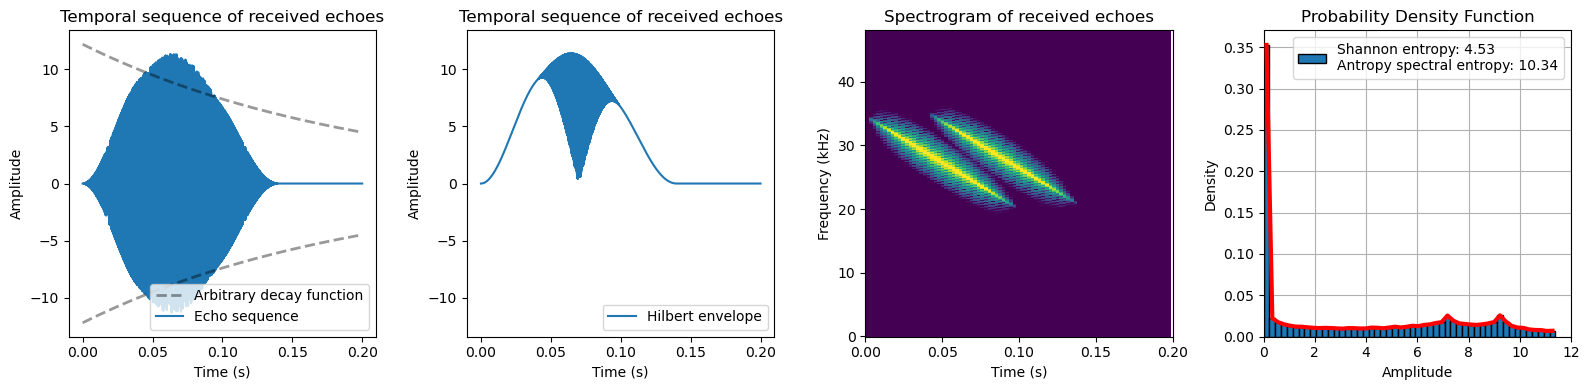

In [ ]:
# def plot_sequence_of_echoes(repeats, decay_delay, overlap_frac, nfft): 
decay_delay = 0.5
nfft = 1024
repeats = 2
overlap_frac = 0.45
overlap = round(overlap_frac, 2)
sig_time = np.linspace(0, TX_DURATION, N)
window = scipy.signal.windows.hann(N)

all_sigs_time = np.linspace(0, repeats*TX_DURATION, int(repeats*N))
sequence_of_echoes = np.zeros(int(repeats*N))
t = 0
if overlap!=0:
    for i in np.arange(0, np.floor(overlap*repeats*100)/100, overlap).round(1):
        sequence_of_echoes[int(i*N):int(i*N) + N] += window*transmits[t]
        t+=1
else:
    for i in range(repeats):
        sequence_of_echoes[:N] += window*transmits[t]
        t+=1
decay = np.exp(-5*(all_sigs_time-decay_delay))
sequence_of_echoes = decay*(sequence_of_echoes)
hilbert_envelope_of_echoes = np.abs(scipy.signal.hilbert(sequence_of_echoes))

fig, ax_all = plt.subplots(1, 4, figsize=(16, 4))
ax = ax_all[0]
ax.set_title('Temporal sequence of received echoes')
ax.plot(all_sigs_time, decay, linestyle='dashed', color='k', alpha=0.4, linewidth=2, label='Arbitrary decay function', zorder=2)
ax.plot(all_sigs_time, -decay, linestyle='dashed', color='k', alpha=0.4, linewidth=2, zorder=2)
ax.plot(all_sigs_time, sequence_of_echoes, alpha=1, label='Echo sequence', zorder=1)
ax.set_ylabel('Amplitude')
ax.set_xlabel('Time (s)')
ax.legend(loc='lower right')

ax = ax_all[1]
ax.set_title('Temporal sequence of received echoes')
ax.plot(all_sigs_time, decay, linestyle='dashed', color='w', alpha=0.4, linewidth=2)
ax.plot(all_sigs_time, -decay, linestyle='dashed', color='w', alpha=0.4, linewidth=2)
ax.plot(all_sigs_time, sequence_of_echoes, alpha=1, color='w')
ax.plot(all_sigs_time, hilbert_envelope_of_echoes, label='Hilbert envelope')
ax.set_ylabel('Amplitude')
ax.set_xlabel('Time (s)')
ax.legend(loc='lower right')

ax = ax_all[2]
freqs, time, Sxx = scipy.signal.spectrogram(sequence_of_echoes, detrend=False, nfft=nfft, fs=FS)
Sxx[np.where(Sxx==0)] = 1e-16
SxxdB = 10 * np.log10(Sxx)
ax.pcolormesh(time, freqs/1e3, SxxdB, vmin=-60, vmax=-20) # manually plot using plt.pcolormesh
ax.set_xlim(0, repeats*TX_DURATION)
ax.set_title('Spectrogram of received echoes')
ax.set_ylabel('Frequency (kHz)')
ax.set_xlabel('Time (s)')

ax = ax_all[3]
counts, bin_edges = np.histogram(hilbert_envelope_of_echoes, bins=50, density=False)
pmf = (counts / counts.sum())
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = np.diff(bin_edges)
ax.plot(bin_centers, pmf, color='r', linewidth=3, zorder=3)
ax.bar(bin_centers, pmf, width=bin_widths, align='center', edgecolor='black', alpha=1, zorder=2,
        label=f'Shannon entropy: {-np.sum(pmf[pmf!=0] * np.log2(pmf[pmf!=0])):.2f}\nAntropy spectral entropy: {ant.spectral_entropy(sequence_of_echoes, sf=FS):.2f}')
ax.set_title('Probability Density Function')
ax.set_xlabel('Amplitude')
ax.set_ylabel('Density')
ax.grid(which='both', zorder=1)
ax.set_xlim(0, np.ceil(hilbert_envelope_of_echoes.max()-0.01))
ax.legend()

fig.tight_layout()
plt.show()

In [35]:
def scan_hilbert_envelope(start, duration):
    x_env, x_res = scipy.signal.envelope(sequence_of_echoes)
    plt.plot(all_sigs_time, decay, linestyle='dashed', color='k', alpha=0.4, linewidth=2, label='Arbitrary decay function', zorder=3)
    plt.plot(all_sigs_time, -decay, linestyle='dashed', color='k', alpha=0.4, linewidth=2, zorder=3)
    plt.plot(all_sigs_time, np.sqrt(sequence_of_echoes**2), alpha=1, label='Echo sequence', zorder=1)
    plt.plot(all_sigs_time, x_env, zorder=2)
    # plt.plot(all_sigs_time, np.sqrt(sequence_of_echoes**2), zorder=2)
    plt.xlim(start, start+duration)
    plt.show()

In [36]:
start_slider = widgets.FloatSlider(
    value=0, min=0, max=0.2, step=0.01, description="Start (s)", continuous_update=True, style={'description_width': 'initial'}, layout=widgets.Layout(width="300px")
)
duration_slider = widgets.FloatSlider(
    value=0.2, min=0.001, max=0.2, step=0.001, description="Durations (s)", continuous_update=True, style={'description_width': 'initial'}, layout=widgets.Layout(width="300px")
)

interactive_plot = widgets.interactive(scan_hilbert_envelope, start=start_slider, duration=duration_slider)
display(interactive_plot)

interactive(children=(FloatSlider(value=0.0, description='Start (s)', layout=Layout(width='300px'), max=0.2, s…